In [1]:
import os, sys, time, pickle, json, math
from tqdm import tqdm
from collections import defaultdict
from itertools import product
import numpy as np
import pandas as pd
import torch
from utils.helper import get_device, json2dict
from utils.vit_util import identfy_tgt_misclf, localize_neurons_with_mean_activation, get_batched_hs, get_batched_labels, ViTFromLastLayer, get_ori_model_predictions, maybe_initialize_repair_weights_
from utils.constant import ViTExperiment, ExperimentRepair1, Experiment3, ExperimentRepair2, Experiment1, Experiment4
from utils.log import set_exp_logging
from utils.arachne import calculate_top_n_flattened, calculate_bi_fi, calculate_pareto_front_flattened, approximate_pareto_front
from logging import getLogger
from datasets import load_from_disk
from transformers import ViTForImageClassification
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

logger = getLogger("base_logger")
device = get_device()

def main(ds_name, k, tgt_rank, misclf_type, fpfn, tgt_layer):
    print(f"ds_name: {ds_name}, fold_id: {k}, tgt_rank: {tgt_rank}, misclf_type: {misclf_type}, fpfn: {fpfn}")
    misclf_ptn = misclf_type if fpfn is None else f"{misclf_type}_{fpfn}"
    
    ts = time.perf_counter()
    
    # datasetをロード (true_labelsが欲しいので)
    ds_dirname = f"{ds_name}_fold{k}"
    ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, ds_dirname))
    if ds_name == "c10" or ds_name == "tiny-imagenet":
        label_col = "label"
    elif ds_name == "c100":
        label_col = "fine_label"
    else:
        raise NotImplementedError(ds_name)
    # ラベルの取得 (shuffleされない)
    labels = {
        "train": np.array(ds["train"][label_col]),
        "repair": np.array(ds["repair"][label_col]),
        "test": np.array(ds["test"][label_col])
    }
    tgt_pos = ViTExperiment.CLS_IDX
    
    # 結果とかログの保存先を先に作っておく
    # pretrained modelのディレクトリ
    pretrained_dir = getattr(ViTExperiment, ds_name.replace("-", "_")).OUTPUT_DIR.format(k=k)
    save_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", f"{misclf_type}_weights_location")
    if misclf_type == "all":
        save_dir = os.path.join(pretrained_dir, f"all_weights_location")
    if fpfn is not None and misclf_type == "tgt":
        save_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", f"{misclf_type}_{fpfn}_weights_location")
    os.makedirs(save_dir, exist_ok=True)

    # tgt_rankの誤分類情報を取り出す
    tgt_split = "repair" # NOTE: we only use repair split for repairing
    # tgt_layer = 11 # NOTE: we only use the last layer for repairing
    misclf_info_dir = os.path.join(pretrained_dir, "misclf_info")
    misclf_pair, tgt_label, tgt_mis_indices = identfy_tgt_misclf(misclf_info_dir, tgt_split=tgt_split, tgt_rank=tgt_rank, misclf_type=misclf_type, fpfn=fpfn)
    
    # original model の repair setの各サンプルに対する正解/不正解のインデックスを取得
    pred_res_dir = os.path.join(pretrained_dir, "pred_results", "PredictionOutput")
    if misclf_type == "tgt":
        ori_pred_labels, _, indices_to_correct_tgt, _, indices_to_correct_others = get_ori_model_predictions(pred_res_dir, labels, tgt_split=tgt_split, misclf_type=misclf_type, tgt_label=tgt_label)
        # mis_clf=tgtでも全ての正解サンプルを選ぶ
        indices_to_correct = np.sort(np.concatenate([indices_to_correct_tgt, indices_to_correct_others]))
    else:
        ori_pred_labels, _, indices_to_correct = get_ori_model_predictions(pred_res_dir, labels, tgt_split=tgt_split, misclf_type=misclf_type, tgt_label=tgt_label)
    print(f"len(indices_to_correct): {len(indices_to_correct)}, len(tgt_mis_indices): {len(tgt_mis_indices)}")
    
    # 中間ニューロン値のキャッシュのロード
    mid_cache_dir = os.path.join(pretrained_dir, f"cache_states_{tgt_split}")
    mid_save_path = os.path.join(mid_cache_dir, f"intermediate_states_l{tgt_layer}.pt")
    cached_mid_states = torch.load(mid_save_path, map_location="cpu") # (tgt_splitのサンプル数(10000), 中間ニューロン数(3072))
    # cached_mid_statesをnumpy配列にする
    cached_mid_states = cached_mid_states.detach().numpy().copy()
    print(f"cached_mid_states.shape: {cached_mid_states.shape}")

    # ===============================================
    # localization phase
    # ===============================================

    vscore_cor_dir = os.path.join(pretrained_dir, "vscores")
    if misclf_type == "src_tgt" or misclf_type == "tgt":
        # vscore_before_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_before")
        vscore_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores")
        # vscore_after_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_after")
    elif misclf_type == "all":
        # vscore_before_dir = os.path.join(pretrained_dir, "vscores_before")
        vscore_dir = os.path.join(pretrained_dir, "vscores")
        # vscore_after_dir = os.path.join(pretrained_dir, "vscores_after")
    # logger.info(f"vscore_before_dir: {vscore_before_dir}")
    logger.info(f"vscore_dir: {vscore_dir}")
    # logger.info(f"vscore_after_dir: {vscore_after_dir}")
    # vscoreとmean_activationを用いたlocalizationを実行
    places_to_neuron, tgt_neuron_score, neuron_scores, _mean_activation, _vmap_diff_abs = localize_neurons_with_mean_activation(None, vscore_dir, None, tgt_layer, n=None, intermediate_states=cached_mid_states, tgt_mis_indices=tgt_mis_indices, misclf_pair=misclf_pair, tgt_label=tgt_label, fpfn=fpfn, return_all_neuron_score=True, vscore_abs=True, covavg=False, vscore_cor_dir=vscore_cor_dir, return_before_norm=True)
    # log表示
    # logger.info(f"places_to_neuron={places_to_neuron}")
    # logger.info(f"num(pos_to_fix)={len(places_to_neuron)}")
    # 位置情報を保存
    # print(f"len(places_to_neuron): {len(places_to_neuron)}")
    # print(f"tgt_neuron_score.shape: {tgt_neuron_score.shape}")
    # print(f"tgt_neuron_score: {tgt_neuron_score}")
    # print(f"neuron_scores.shape: {neuron_scores.shape}")
    # print(f"neuron_scores: {neuron_scores}")
    # print(np.min(neuron_scores), np.max(neuron_scores), np.mean(neuron_scores), np.std(neuron_scores))
    return _mean_activation, _vmap_diff_abs

2025-07-30 19:33:43.370974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 19:33:43.586728: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 19:33:44.330213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-07-30 19:33:44.330290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Device: cuda
Device: cuda


In [42]:
def get_plot(ds):
    # ------------------------------------------------------------
    # 設定
    # ------------------------------------------------------------
    # ds            = "c100"              # "c10", "c100", "tiny-imagenet"
    # ds            = "tiny-imagenet"              # "c10", "c100", "tiny-imagenet"
    k_list        = [0]
    tgt_rank_list = range(1, 4)         # 1,2,3
    misclf_type_list = ["src_tgt", "tgt"]
    fpfn_list        = [None, "fp", "fn"]

    plots = {}  # key = (rank, col_idx) -> (mean, lower, upper)

    for k, tgt_rank, misclf_type, fpfn in product(
            k_list, tgt_rank_list, misclf_type_list, fpfn_list):

        # 無効な組合せはスキップ
        if (misclf_type in ["src_tgt", "all"]) and fpfn is not None:
            continue
        if (misclf_type == "tgt") and fpfn is None:
            continue

        print(f"\nStart: ds={ds}, k={k}, rank={tgt_rank}, "
                f"type={misclf_type}, fpfn={fpfn}\n"
                "------------------------------------------------------------")

        # -------------------------
        # 各層の vdiff と mma を収集
        # -------------------------
        vdiff_layers, mma_layers = [], []          # shape → (12, 3072)
        for tl in range(12):
            mma_layer, vdiff_layer = main(ds, k, tgt_rank,
                                            misclf_type, fpfn,
                                            tgt_layer=tl)
            # 返り値の順が逆なら ↓ を swap してください
            mma_layers.append(mma_layer)
            vdiff_layers.append(vdiff_layer)

        vdiff = np.array(vdiff_layers)  # (12, 3072)
        mma   = np.array(mma_layers)    # (12, 3072)

        # -------------------------
        # A. 全体 Min‑Max 正規化 → 掛け算
        # -------------------------
        v_min, v_max = vdiff.min(), vdiff.max()
        m_min, m_max = mma.min(),   mma.max()

        # ε を足して 0 除防止
        v_scaled = (vdiff - v_min) / (v_max - v_min + 1e-12)
        m_scaled = (mma   - m_min) / (m_max - m_min + 1e-12)
        # v_scaled = vdiff
        # m_scaled = mma

        score = v_scaled * m_scaled          # (12, 3072)

        # -------------------------
        # 層平均と 95 % CI
        # -------------------------
        means = score.mean(axis=1)
        sem   = score.std(axis=1, ddof=1) / math.sqrt(score.shape[1])
        delta = 1.96 * sem
        lower, upper = means - delta, means + delta

        # 列インデックス決定
        col_idx = 0 if misclf_type == "src_tgt" else (1 if fpfn == "fp" else 2)
        plots[(tgt_rank, col_idx)] = (means, lower, upper)
    return plots

In [43]:
plots_dic = {}
for ds in ["c100", "tiny-imagenet"]:
    plots_dic[ds] = get_plot(ds)


Start: ds=c100, k=0, rank=1, type=src_tgt, fpfn=None
------------------------------------------------------------
ds_name: c100, fold_id: 0, tgt_rank: 1, misclf_type: src_tgt, fpfn: None
len(indices_to_correct): 9074, len(tgt_mis_indices): 19
cached_mid_states.shape: (10000, 3072)
vscore_save_path: /src/src/out_vit_c100_fold0/vscores/vscore_abs_l1tol12_label_47_ori_repair_cor.npy
vscore_save_path: /src/src/out_vit_c100_fold0/misclf_top1/vscores/vscore_abs_l1tol12_52to47_ori_repair_mis.npy
ds_name: c100, fold_id: 0, tgt_rank: 1, misclf_type: src_tgt, fpfn: None
len(indices_to_correct): 9074, len(tgt_mis_indices): 19
cached_mid_states.shape: (10000, 3072)
vscore_save_path: /src/src/out_vit_c100_fold0/vscores/vscore_abs_l1tol12_label_47_ori_repair_cor.npy
vscore_save_path: /src/src/out_vit_c100_fold0/misclf_top1/vscores/vscore_abs_l1tol12_52to47_ori_repair_mis.npy
ds_name: c100, fold_id: 0, tgt_rank: 1, misclf_type: src_tgt, fpfn: None
len(indices_to_correct): 9074, len(tgt_mis_indices):

Saved grid plot to neuron_scores_grid_c100.pdf
Saved grid plot to neuron_scores_grid_tiny-imagenet.pdf


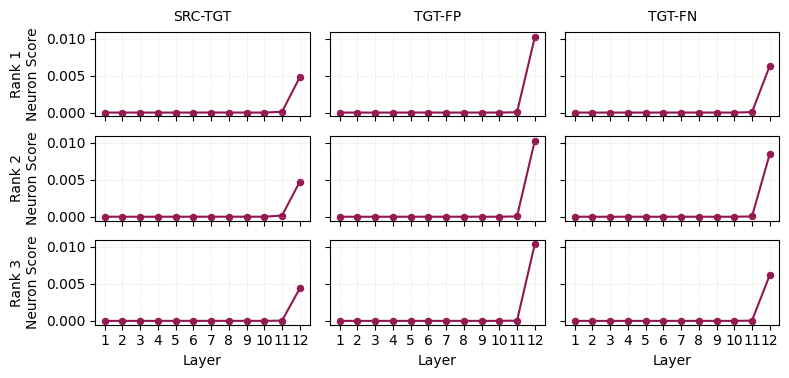

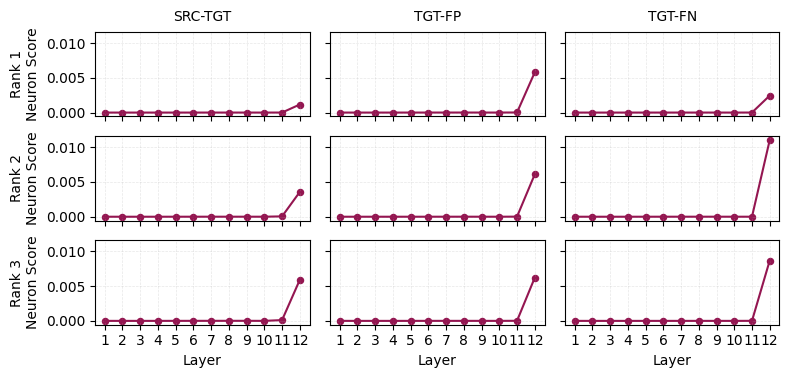

In [44]:
for ds in ["c100", "tiny-imagenet"]:
    plots = plots_dic[ds]

    # ------------------------------------------------------------
    # グリッド描画
    # ------------------------------------------------------------
    layer_idx  = np.arange(1, 13)            # 1‑based
    col_titles = ["SRC-TGT", "TGT-FP", "TGT-FN"]

    fig, axes = plt.subplots(3, 3, figsize=(8, 4),
                                sharex=True, sharey=True)

    for rank in range(1, 4):
        for col in range(3):
            ax = axes[rank-1, col]
            means, lower, upper = plots[(rank, col)]

            # ax.fill_between(layer_idx, lower, upper, color='#941651', alpha=0.25)
            ax.plot(layer_idx, means, '-', color='#941651', lw=1.5, )
            # 丸い点をscatterで描画（サイズや枠線色を細かく調整可能）
            ax.scatter(
                layer_idx, means,
                s=15,                          # 丸のサイズ
                facecolors='#941651',            # 中身の色（白抜き）
                edgecolors='#941651',          # 枠を黒に
                linewidths=1.5                 # 枠線の太さ
            )

            if col == 0:
                ax.set_ylabel(f"Rank {rank}\nNeuron Score", fontsize=10)
            if rank == 3:
                ax.set_xlabel("Layer")

            if rank == 1:
                ax.set_title(col_titles[col], fontsize=10, pad=8)

            ax.set_xticks(layer_idx)
            ax.grid(alpha=.3, linestyle='--', linewidth=.5)
            

    # fig.suptitle("Mean ± 95% CI of Neuron Scores per Layer", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    save_name = f"neuron_scores_grid_{ds}.pdf"
    # plt.show()
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
    print(f"Saved grid plot to {save_name}")